# Problem Statement

The task is to accurately classify jellyfish species from images. Accurate identification of jellyfish species is crucial for marine biodiversity studies, ecosystem monitoring, and managing jellyfish blooms that can impact tourism and fishing industries.

## Importance:

Environmental Monitoring: 
Helps in monitoring marine biodiversity and detecting changes in jellyfish populations due to climate change or pollution.
Economic Impact:
Supports the fishing and tourism industries by managing jellyfish blooms that can damage fishing equipment and deter tourists.
Research and Conservation: 
Assists marine biologists in studying jellyfish behavior, distribution, and interactions within the ecosystem.

## Dataset information

# Task

The problem can be formulated as a supervised learning task where the goal is to predict product recommendations based on images. This involves training a deep neural network on image data, where the input is an image and the output is a set of recommended products.

## Importing library

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt



In [2]:
pip install tensorflow numpy matplotlib


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Path to the dataset directory
data_dir = '/Users/mandeepsinghsahani/Downloads/Jelly/'
categories = ['moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']

# Data Exploration

## Dataset Characteristics

Found 900 files belonging to 6 classes.


2024-06-26 16:15:59.148668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


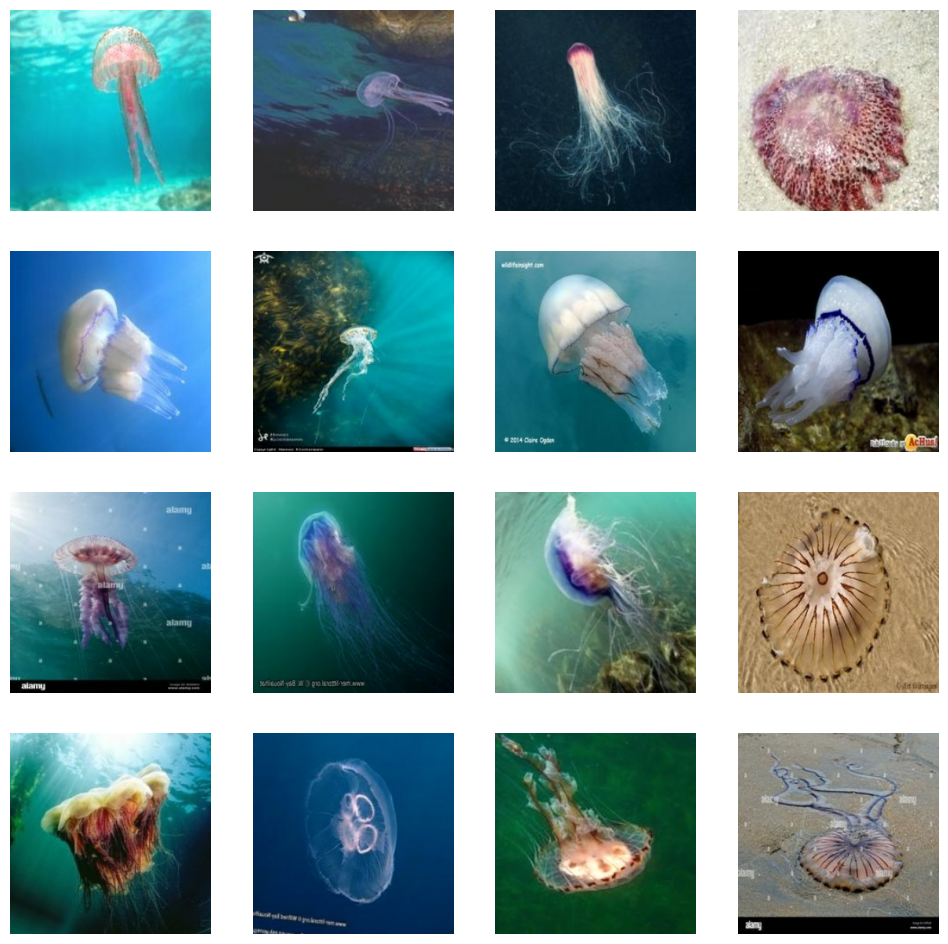

In [4]:
# Assuming you have a function to load images from a directory
def load_images_from_directory(directory):
    # Assuming you use tf.keras.preprocessing.image_dataset_from_directory or similar
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        batch_size=16  # Adjust batch size as needed
    )

# Load the dataset from directory
dataset = load_images_from_directory(data_dir)

# Visualize images
plt.figure(figsize=(12, 12))
for images, labels in dataset.take(1):  # Take the first batch of images
    for i in range(16):  # Display 16 images from the batch
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to numpy array and ensure uint8 dtype
        plt.axis('off')  # Turn off axis
plt.show()


## 1  Checking Image Sizes and Color Channels


# Function to check image sizes and color channels

In [5]:
def check_image_sizes_and_channels(data_dir, categories):
    image_sizes = []
    color_channels = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        if os.path.exists(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    image_sizes.append(img.shape)
                    color_channels.append(img.shape[2])
                else:
                    print(f"Unable to read image: {img_path}")
    return image_sizes, color_channels

image_sizes, color_channels = check_image_sizes_and_channels(data_dir, categories)
image_sizes_df = pd.DataFrame(image_sizes, columns=['Height', 'Width', 'Channels'])

# Display image sizes statistics
print(image_sizes_df.describe())

# Verify color channels
print("Color Channels Distribution:", pd.Series(color_channels).value_counts())


           Height       Width  Channels
count  900.000000  900.000000     900.0
mean   210.600000  210.600000       3.0
std     20.589099   20.589099       0.0
min    179.000000  179.000000       3.0
25%    179.000000  179.000000       3.0
50%    224.000000  224.000000       3.0
75%    224.000000  224.000000       3.0
max    224.000000  224.000000       3.0
Color Channels Distribution: 3    900
Name: count, dtype: int64


## Step 2: Checking Class Distribution

                  Category  Count
0           moon_jellyfish    150
1         barrel_jellyfish    150
2           blue_jellyfish    150
3        compass_jellyfish    150
4     lions_mane_jellyfish    150
5  mauve_stinger_jellyfish    150


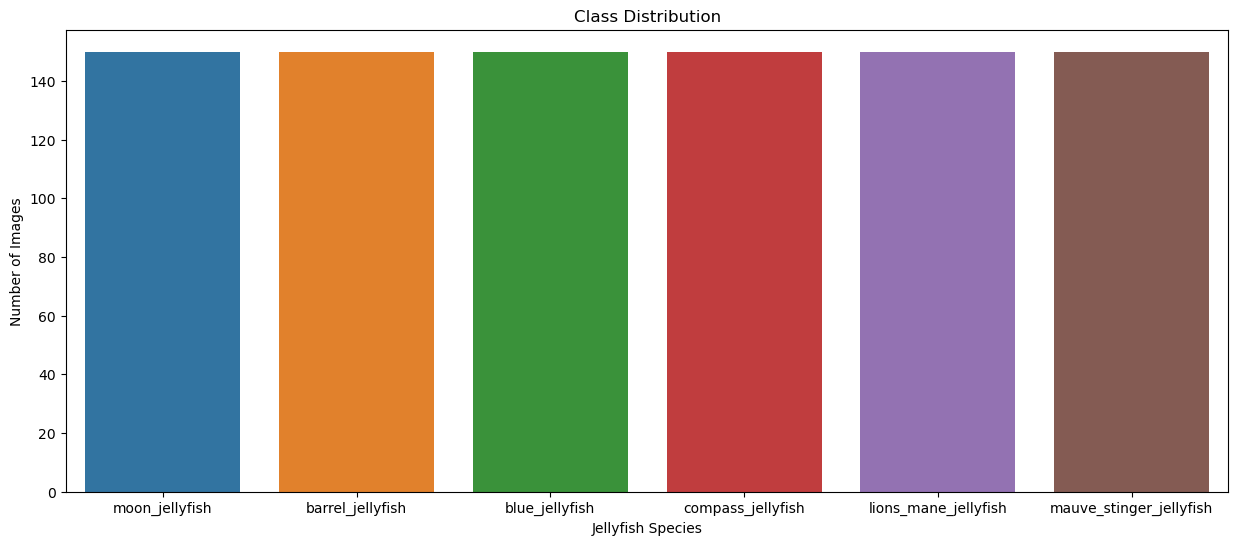

In [6]:
# Function to check class distribution
def check_class_distribution(data_dir, categories):
    class_counts = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        if os.path.exists(category_path):
            class_counts.append(len(os.listdir(category_path)))
    return class_counts

class_counts = check_class_distribution(data_dir, categories)
class_distribution_df = pd.DataFrame({'Category': categories, 'Count': class_counts})

# Display class distribution
print(class_distribution_df)

plt.figure(figsize=(15, 6))
sns.barplot(x='Category', y='Count', data=class_distribution_df)
plt.title('Class Distribution')
plt.xlabel('Jellyfish Species')
plt.ylabel('Number of Images')
plt.show()


## Step 3: Resizing Images and Handling Class Imbalance

In [15]:
# Resizing images and creating an augmented data generator
img_size = (128, 128)
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [16]:
# Function to load and resize images
def load_and_resize_images(data_dir, categories, img_size):
    data = []
    labels = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        if os.path.exists(category_path):
            class_num = categories.index(category)
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img_resized = cv2.resize(img, img_size)
                    data.append(img_resized)
                    labels.append(class_num)
                else:
                    print(f"Unable to read image: {img_path}")
    return np.array(data), np.array(labels)

X, y = load_and_resize_images(data_dir, categories, img_size)

In [17]:
# Splitting dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [18]:
# Applying data augmentation to the training set
train_datagen = datagen.flow(X_train, y_train, batch_size=32)

In [19]:
# Check the shape of the datasets
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (720, 128, 128, 3)
Validation set shape: (90, 128, 128, 3)
Test set shape: (90, 128, 128, 3)


## Step 3: Model Evaluation Metrics

In [23]:
# Image size and data loading
img_size = (128, 128)
X, y = load_and_resize_images(data_dir, categories, img_size)

# One-hot encode labels
num_classes = len(categories)
y = to_categorical(y, num_classes)

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [24]:

# Create the model
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
input_shape = (128, 128, 3)
model = create_model(input_shape, num_classes)



/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# Training the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val / 255.0, y_val)
)

Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.1928 - loss: 1.9400 - val_accuracy: 0.2778 - val_loss: 1.7016
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.2854 - loss: 1.6859 - val_accuracy: 0.4222 - val_loss: 1.4089
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.3252 - loss: 1.5699 - val_accuracy: 0.5111 - val_loss: 1.3576
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.4414 - loss: 1.4679 - val_accuracy: 0.4333 - val_loss: 1.3196
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.4245 - loss: 1.4088 - val_accuracy: 0.4889 - val_loss: 1.2493
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.4372 - loss: 1.3583 - val_accuracy: 0.5000 - val_loss: 1.2369
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.4661 - loss: 1.3503 - val_accuracy: 0.6000 - val_loss: 1.1104
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.4976 - loss: 1.2583 - val_accuracy: 0.5444 - val_

In [27]:
# Classification report
print(classification_report(y_true, y_pred_classes, target_names=categories))


                         precision    recall  f1-score   support

         moon_jellyfish       1.00      0.80      0.89        15
       barrel_jellyfish       0.81      0.87      0.84        15
         blue_jellyfish       0.85      0.73      0.79        15
      compass_jellyfish       0.71      0.80      0.75        15
   lions_mane_jellyfish       0.60      0.80      0.69        15
mauve_stinger_jellyfish       0.83      0.67      0.74        15

               accuracy                           0.78        90
              macro avg       0.80      0.78      0.78        90
           weighted avg       0.80      0.78      0.78        90



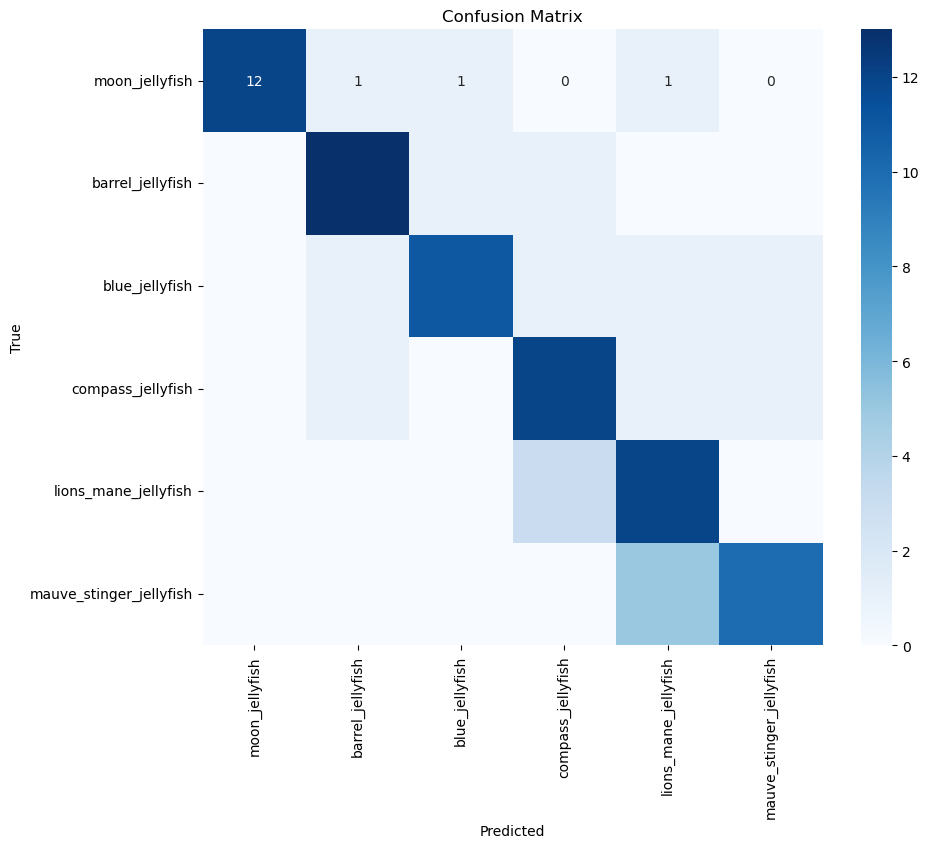

In [28]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()